##### Pset 2

In [1]:
import pandas as pd
import numpy as np

In [2]:
import scipy.io
mat = scipy.io.loadmat('../data/census.mat')

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
data = pd.DataFrame(np.array([mat["educ"], mat["y"], mat["yob"]]).reshape([3, 329509])).transpose()

In [5]:
data.columns = ["educ", "y", "yob"]

In [6]:
res = smf.ols("y ~ educ + C(yob)", data = data).fit()

In [7]:
data["const"] = 1

##### Question 1

a)

##### Treatment effect - Overall

In [8]:
data.groupby("yob")["educ"].mean()

yob
30.0    0.364175
31.0    0.382794
32.0    0.388315
33.0    0.394068
34.0    0.396604
35.0    0.403167
36.0    0.405374
37.0    0.407136
38.0    0.414985
39.0    0.419746
Name: educ, dtype: float64

##### The support of the treatment probability at the cluster level is not 0 or 1.

##### Compute two estimators of the treatment effect, one using OLs and one using fixed effects

In [9]:
def get_OLS(data):
    
    X = data[["const", "educ"]].to_numpy()
    Y = data[["y"]].to_numpy()
    
    beta = np.linalg.inv(X.transpose()@X) @ X.transpose()@Y
    
    errors = Y - X @ beta

    t_pop = beta[1]
    
    return t_pop, errors, X, beta

In [10]:
t_pop, errors, X, _ = get_OLS(data)

In [11]:
data['errors_ols'] = errors

In [12]:
t_pop

array([0.37765759])

In [13]:
def get_fe(data):
    
    #OLS with fixed effects
    X_fe = data.groupby("yob").apply(lambda y: y-y.mean())[["educ"]].to_numpy()
    Y_fe = data.groupby("yob").apply(lambda y: y-y.mean())[["y"]].to_numpy()
    
    beta_fe = np.linalg.inv(X_fe.transpose()@X_fe) @ X_fe.transpose()@Y_fe
    
    t_fe = beta_fe[0]
    errors_fe = Y_fe - X_fe @beta_fe

    return t_fe, errors_fe, X_fe

In [14]:
t_fe, errors_fe, X_fe = get_fe(data)

In [15]:
data['errors_fe'] = errors_fe

In [16]:
t_fe

array([0.37817221])

##### Using standard OLS formula for homoskedastic variance

In [17]:
(np.linalg.inv(X.transpose() @ X) * errors.var())[1,1]**0.5

0.00232455626992343

In [18]:
##### Using standard OLS formula for homoskedastic variance

In [19]:
(np.linalg.inv(X_fe.transpose() @ X_fe) * errors_fe.var())[0,0]**0.5

0.002325564247232883

##### Neyman variance (OLS)

In [20]:
N = data.shape[0]

M = data["educ"].sum()

In [21]:
s2_T = errors[(data["educ"] == 1)].var()
s2_C = errors[(data["educ"] == 0)].var()

In [22]:
V_neyman = s2_T/(M) + s2_C/(N-M)

In [23]:
V_neyman ** 0.5

0.0023100110595997573

##### Neyman variance

In [24]:
from numpy.linalg import inv

In [25]:
# Calculate the inverse matrix once and store it
X_T_X_inv = np.linalg.inv(X.T @ X)

# Extract the squared errors vector
squared_errors = (errors ** 2)[:,0]

middle = X.T * squared_errors @ X  # Element-wise multiplication with broadcasting

# Compute the final result
V_EHW = X_T_X_inv @ middle @ X_T_X_inv


In [26]:
V_EHW[1,1]**0.5

0.002310011059599756

##### Neyman variance (FE)

In [27]:
# Calculate the inverse matrix once and store it
X_T_X_inv_fe = np.linalg.inv(X_fe.T @ X_fe)

# Extract the squared errors vector
squared_errors_fe = (errors_fe ** 2)[:,0]

middle_fe = X_fe.T * squared_errors_fe @ X_fe  # Element-wise multiplication with broadcasting

# Compute the final result
V_EHW_fe = X_T_X_inv_fe @ middle_fe @ X_T_X_inv_fe


In [28]:
V_EHW_fe[0,0]**0.5

0.002311037801469186

b)

Bootstrap

In [29]:
n_b = 10
#n_sample = 20000

In [30]:
from tqdm import tqdm

In [31]:
t_pop_boot = []
t_fe_boot = []
for i in tqdm(range(n_b)):
    sample = data.loc[np.random.choice(data.index, size = N, replace = True)]
    t_pop_boot.append(get_OLS(sample)[0][0])
    t_fe_boot.append(get_fe(sample)[0][0])

100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


In [32]:
import seaborn as sns

In [33]:
import matplotlib.pyplot as plt

In [34]:
std_pop = np.std(t_pop_boot)

In [35]:
std_fe = np.std(t_fe_boot)

Text(0.38, 160, 'STD Boot:0.002')

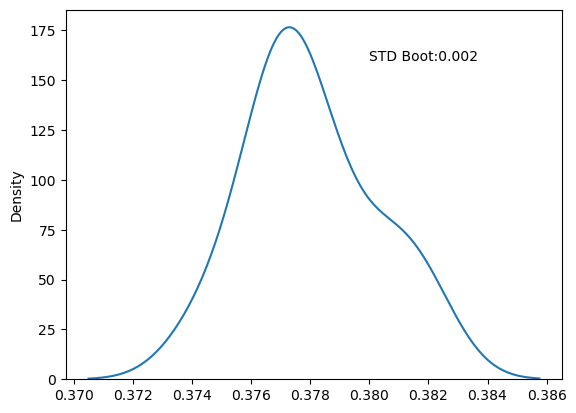

In [36]:
sns.kdeplot(t_pop_boot)
# Annotate a point
plt.annotate(
    f'STD Boot:{std_pop:.2}', # The text to display
    xy=(0.38, 160), # The point (x, y) to annotate
    xytext=(0.38, 160), # The position (x, y) to place the text
    arrowprops=None
)

Text(0.38, 160, 'STD Boot:0.002')

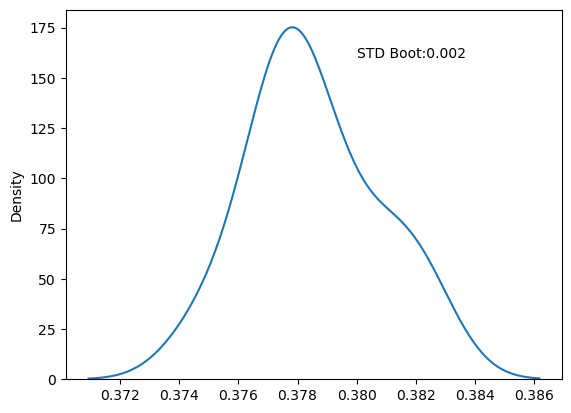

In [37]:
sns.kdeplot(t_fe_boot)
# Annotate a point
plt.annotate(
    f'STD Boot:{std_fe:.2}', # The text to display
    xy=(0.38, 160), # The point (x, y) to annotate
    xytext=(0.38, 160), # The position (x, y) to place the text
    arrowprops=None
)

c)

In [38]:
middle_cluster = np.zeros([X.shape[1], X.shape[1]])

for cluster in data["yob"].unique():
    
    X_g = X[data["yob"] == cluster,:]
    errors_g = errors[data["yob"] == cluster,:]
    middle_cluster += np.sum(X_g * errors_g, axis = 0).T @ np.sum(X_g * errors_g, axis = 0)

In [39]:
V_LZ = X_T_X_inv @ middle_cluster @ X_T_X_inv

In [40]:
V_LZ[1,1]**0.5

0.008415067653132002

In [41]:
middle_cluster_fe = np.zeros([X_fe.shape[1], X_fe.shape[1]])

for cluster in data["yob"].unique():
    
    X_g_fe = X_fe[data["yob"] == cluster,:]
    errors_g_fe = errors_fe[data["yob"] == cluster,:]
    middle_cluster_fe += np.sum(X_g_fe * errors_g_fe, axis = 0).T @ np.sum(X_g_fe * errors_g_fe, axis = 0)

In [42]:
V_LZ_fe = X_T_X_inv_fe @ middle_cluster_fe @ X_T_X_inv_fe

In [43]:
V_LZ_fe[0,0]**0.5

0.00473606928013595

d)

In [44]:
fractions = data.groupby("yob")["educ"].mean()

In [45]:
observation =  data.groupby("yob")["y"].count()

In [46]:
t_pop_boot_cl = []
t_fe_boot_cl = []

for i in tqdm(range(n_b)):
    sample = pd.DataFrame()
    for cluster in observation.index:
        
        draw_fraction = np.random.choice(fractions.values, 1)[0]
        
        N_t = observation[cluster]
        
        M_t = int(observation[cluster] * draw_fraction)
        
        sample_m = data.loc[np.random.choice(data[(data.yob == cluster) & (data.educ == 1)].index, M_t)]
        sample_nm = data.loc[np.random.choice(data[(data.yob == cluster) & (data.educ == 0)].index, N_t - M_t)]
    
        sample = pd.concat([sample, sample_m, sample_nm])
    t_pop_boot_cl.append(get_OLS(sample)[0][0])
    t_fe_boot_cl.append(get_fe(sample)[0][0])

100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


In [47]:
np.std(t_pop_boot_cl)

0.002580915646312353

In [48]:
np.std(t_fe_boot_cl)

0.002620869856775381

e)

In [49]:
data_cl = data.merge(data.groupby("yob")["educ"].mean().rename("educ_cl").reset_index()).merge(data.groupby("yob")["y"].mean().rename("y_cl").reset_index())

In [50]:
data_cl["error_educ"] = data_cl["educ"] -  data_cl["educ_cl"] 
data_cl["error_y"] = data_cl["y"] -  data_cl["y_cl"] 

##### Within cluster correlation of log-earnings

In [51]:
var_y, var_y_cl, var_y_error = np.diag(data_cl[["y", "y_cl", "error_y"]].cov())

In [52]:
var_y_cl / var_y_error

2.9905755253532846e-05

f)

##### Within cluster correlation of log-earnings

In [53]:
var_t, var_t_cl, var_t_error = np.diag(data_cl[["educ", "educ_cl", "error_educ"]].cov())

In [54]:
var_t_cl / var_t_error

0.001035289357518583

g) We could report the causal cluster variance

In [120]:
from modules import compute_CCV

In [168]:
bar_Z = 0.5

In [169]:
data["Z"] = np.random.choice([0,1], size = data.shape[0])

In [170]:
data['u'] = data['Z']
data['Y'] = data['y']
data['state'] = data['yob']

In [171]:
float

float

In [172]:
compute_CCV(data, 0, 'educ', 1)

3.9267502391449978

In [173]:
compute_CCV(data, 1, 'educ', 0)

3.854224011240271

In [174]:
#Estimate the treatment effects using Z = 0

In [175]:
data_0 = data[data.Z == 0]
data_1 = data[data.Z == 1]

In [176]:
t_0, errors_0, X_0, beta = get_OLS(data_0)

In [177]:
data_1['errors_star'] = data_1[['y']].values - data_1[['const', 'educ']].values @ beta

/tmp/ipykernel_34563/1154524974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['errors_star'] = data_1[['y']].values - data_1[['const', 'educ']].values @ beta


In [178]:
# Estimating t_km per cluster

In [179]:
data_0['error_0'] = errors_0

/tmp/ipykernel_34563/2397944678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_0['error_0'] = errors_0


In [180]:
tkm = data_0.groupby(['yob', 'educ'])['y'].mean().unstack('educ').pipe(lambda df: df[1] - df[0])

In [181]:
tkm_tk = tkm - t_0

In [182]:
bar_W = data.educ.mean()
#bar_W = fractions.mean()

In [183]:
data_1['W_bar_W'] = data_1['educ'] - bar_W

/tmp/ipykernel_34563/267994187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['W_bar_W'] = data_1['educ'] - bar_W


In [184]:
data_1 = data_1.merge(tkm_tk.rename('tkm_tk').reset_index())

In [185]:
data_1['C'] = (data_1['W_bar_W'] * data_1['errors_star'] - data_1['tkm_tk'] * bar_W * (1-bar_W))

In [192]:
((1/(bar_Z ** 2) * (data_1.groupby('yob')['C'].sum() ** 2).sum()  - bar_Z / (bar_Z**2) * (data_1['C'] ** 2).sum()) * 1/(N * bar_W ** 2 * (1 - bar_W) **2) 
 + (tkm_tk * data.groupby(['yob'])['y'].count()/data.groupby(['yob'])['y'].count().sum()).sum()
)

3.9363779027843937

Not good estimator / might be something wrong with the underlying data

For the fixed effects one

0.05725518787802391

In [202]:
lambda_k =1 - (fractions*(1-fractions)).mean() ** 2 / ((fractions*(1-fractions))**2).mean()

In [203]:
V_CCV_fe = lambda_k * V_LZ_fe[0,0] + (1 - lambda_k) * V_EHW_fe[0,0]

In [205]:
V_CCV_fe ** 0.5

0.002311760722132041

##### Question 2

a)

I would report the FE-CCV. Since this is the most correct one. Nevertheless, since the cluster component seems to be a a not important component of the varibility observed in the outcome, the standard errors reported using the robust version won't be so different.

b)

In [206]:
fractions


yob
30.0    0.364175
31.0    0.382794
32.0    0.388315
33.0    0.394068
34.0    0.396604
35.0    0.403167
36.0    0.405374
37.0    0.407136
38.0    0.414985
39.0    0.419746
Name: educ, dtype: float64

In [207]:
fractions.mean()

0.3976363242160999

In [208]:
fractions.mean() * (1-fractions.mean()) ** 0.5

0.30861386806538577

In [209]:
fractions.var()

0.0002679053097953354

This because the variance of $A_{k, g}$ is close to 0. At most I'd use the CCV. The clustered adjusted variance seems to be an overadjustment for the standard errors.